## Applying Machine Learning in Communication Networks
##### Columns Overview
- Time: Timestamp of the record.
- BS: Base Station identifier.
- Energy: Energy consumption.
- load: Network load.
- ESMODE: Energy-saving mode status.
- TXpower: Transmission power.

##### Checkpoint problematic : 
Network operational expenditure (OPEX) already accounts for around 25 percent of the total telecom operator’s cost, and 90 percent of it is spent on large energy bills. More than 70 percent of this energy is estimated to be consumed by the radio access network (RAN), particularly by the base stations (BSs). Thus, the objective is to build and train a ML model to estimate the energy consumed by different 5G base stations taking into consideration the impact of various engineering configurations, traffic conditions, and energy-saving methods.

In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the dataset
df=pd.read_csv("5G_energy_consumption_dataset.csv")

In [5]:
#inspect the dataset
df.head()

,Time,BS,Energy,load,ESMODE,TXpower
0,20230101 010000,B_0,64.275037,0.487936,0.0,7.101719
1,20230101 020000,B_0,55.904335,0.344468,0.0,7.101719
2,20230101 030000,B_0,57.698057,0.193766,0.0,7.101719
3,20230101 040000,B_0,55.156951,0.222383,0.0,7.101719
4,20230101 050000,B_0,56.053812,0.175436,0.0,7.101719


In [7]:
#total number of rows and columns
df.shape

(92629, 6)

In [9]:
#datatype of the dataset
df.dtypes

Time        object
BS          object
Energy     float64
load       float64
ESMODE     float64
TXpower    float64
dtype: object

In [11]:
#check for missing values
df.isnull().sum()

Time       0
BS         0
Energy     0
load       0
ESMODE     0
TXpower    0
dtype: int64

In [13]:
#check duplicated values
df.duplicated().sum()

0

### Exploratory Data Analysis

In [16]:
df.describe()

,Energy,load,ESMODE,TXpower
count,92629.000000,92629.000000,92629.000000,92629.000000
mean,28.138997,0.244705,0.081361,6.765427
std,13.934645,0.234677,0.382317,0.309929
min,0.747384,0.000000,0.000000,5.381166
25%,18.236173,0.057370,0.000000,6.427504
50%,24.065770,0.165550,0.000000,6.875934
75%,35.724963,0.363766,0.000000,6.875934
max,100.000000,0.993957,4.000000,8.375336


#### Detecting outliers

In [19]:
Q1 = df.Energy.quantile(0.25)
Q3 = df.Energy.quantile(0.75)
Q1, Q3

IQR= Q3-Q1
IQR

17.48878924

In [21]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(-7.997010469999996, 61.95814649)

In [23]:
#To get the outliers
df[(df.Energy < lower_limit) | (df.Energy > upper_limit)]

,Time,BS,Energy,load,ESMODE,TXpower
0,20230101 010000,B_0,64.275037,0.487936,0.0,7.101719
5,20230101 070000,B_0,82.959641,0.351585,0.0,7.101719
6,20230101 080000,B_0,91.031390,0.759298,0.0,7.101719
7,20230101 090000,B_0,78.176383,0.887798,0.0,7.101719
8,20230101 100000,B_0,72.645740,0.624745,0.0,7.101719
...,...,...,...,...,...,...
92205,20230102 130000,B_983,64.573991,0.452729,0.0,8.375336
92206,20230102 150000,B_983,74.588939,0.573759,0.0,8.375336
92208,20230102 170000,B_983,64.275037,0.465338,0.0,8.375336
92209,20230102 180000,B_983,82.212257,0.634722,0.0,8.375336


In [25]:
#the whole dataset without the outliers. it will automatially drop the outliers in the dataset
df_no_outlier = df[(df.Energy > lower_limit) & (df.Energy < upper_limit)]
df_no_outlier = df_no_outlier.drop(["Time", "BS"], axis=1)
df_no_outlier

,Energy,load,ESMODE,TXpower
1,55.904335,0.344468,0.0,7.101719
2,57.698057,0.193766,0.0,7.101719
3,55.156951,0.222383,0.0,7.101719
4,56.053812,0.175436,0.0,7.101719
20,55.754858,0.210952,0.0,7.101719
...,...,...,...,...
92624,14.648729,0.087538,0.0,7.325859
92625,14.648729,0.082635,0.0,7.325859
92626,13.452915,0.055538,0.0,7.325859
92627,13.602392,0.058077,0.0,7.325859


In [27]:
df["BS"].unique()

array(['B_0', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8',
       'B_9', 'B_10', 'B_11', 'B_12', 'B_14', 'B_15', 'B_16', 'B_17',
       'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25',
       'B_26', 'B_27', 'B_28', 'B_29', 'B_30', 'B_31', 'B_32', 'B_33',
       'B_34', 'B_35', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41',
       'B_42', 'B_43', 'B_44', 'B_45', 'B_46', 'B_47', 'B_48', 'B_49',
       'B_50', 'B_51', 'B_52', 'B_53', 'B_54', 'B_55', 'B_56', 'B_57',
       'B_58', 'B_59', 'B_60', 'B_61', 'B_62', 'B_63', 'B_64', 'B_65',
       'B_66', 'B_67', 'B_68', 'B_69', 'B_70', 'B_71', 'B_72', 'B_73',
       'B_74', 'B_75', 'B_76', 'B_77', 'B_78', 'B_79', 'B_80', 'B_81',
       'B_82', 'B_83', 'B_84', 'B_85', 'B_86', 'B_87', 'B_88', 'B_89',
       'B_90', 'B_91', 'B_92', 'B_93', 'B_94', 'B_95', 'B_96', 'B_97',
       'B_98', 'B_99', 'B_100', 'B_101', 'B_102', 'B_103', 'B_104',
       'B_105', 'B_106', 'B_107', 'B_108', 'B_109', 'B_110', 'B_111',
       'B_11

Note: The BS(Base Station Identifier) will be dropped because it is irrelevant and the unique values are up to 1018. Note: It can be encoded if it needs to be added to the features. This should be preferraby done by checking the correlations.

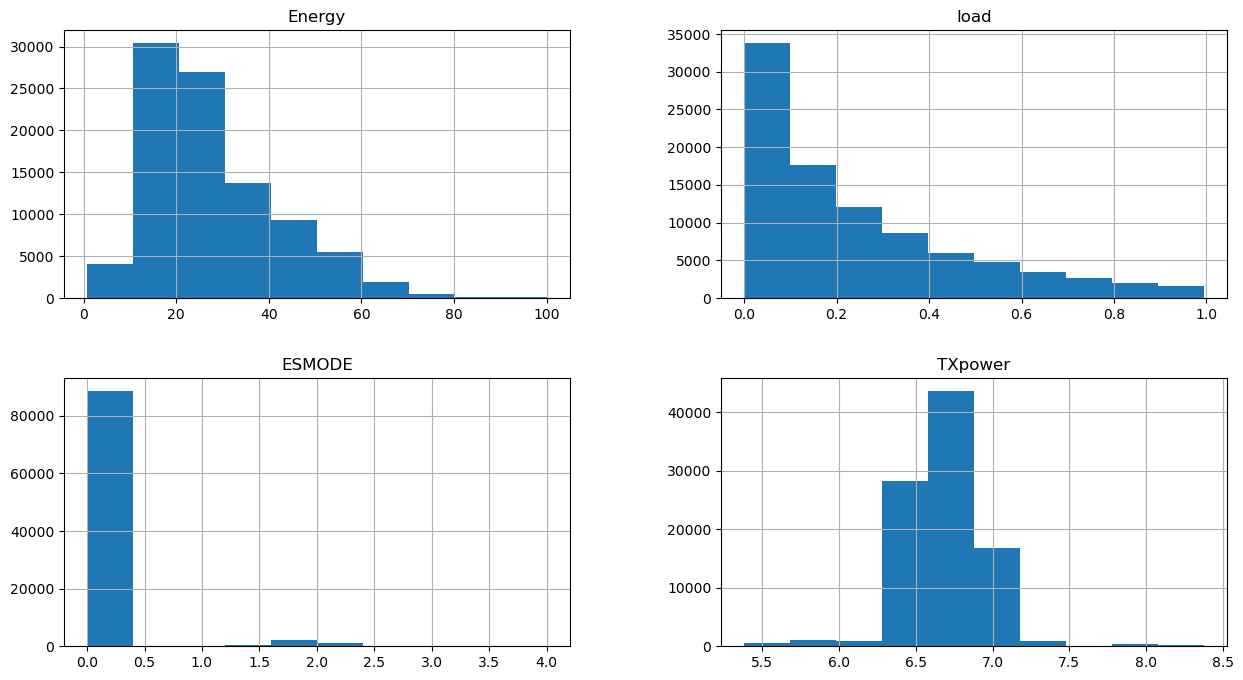

In [30]:
df.hist(figsize=(15, 8));

In [32]:
def draw_regplot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        #dataframe[feature].hist(bins =20,ax=ax,facecolor='midnightblue')
        sns.regplot(data=dataframe, x =dataframe[feature], y= "Energy")
        ax.set_title(feature+" Regression plot",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
#draw_regplot(data,data.columns,6,3)

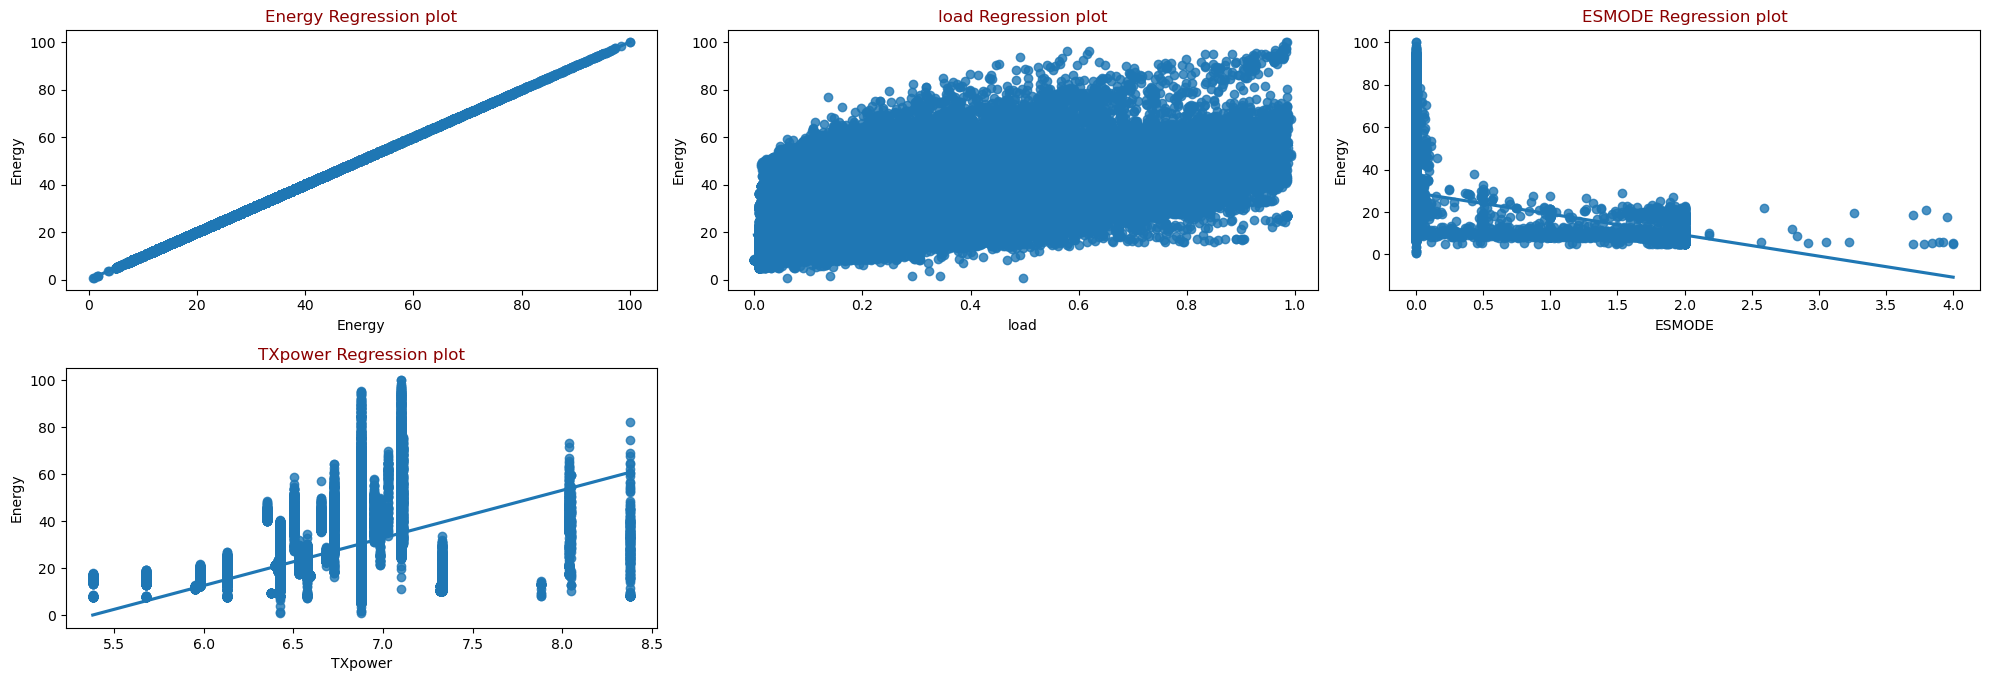

In [36]:
num_col = df.select_dtypes("number")
draw_regplot(num_col, num_col.columns, 6,3)

In [40]:
#checking the correlation between target variable and other numerical variable
df.select_dtypes("number").corr()

,Energy,load,ESMODE,TXpower
Energy,1.000000,0.643022,-0.271783,0.450760
load,0.643022,1.000000,-0.208473,0.200221
ESMODE,-0.271783,-0.208473,1.000000,0.060017
TXpower,0.450760,0.200221,0.060017,1.000000


Note: ESMODE has a negative correlation. It won't be used as one of the features.

**Select Target Variable and Features**

In [46]:
# Selecting features and target variable
y = 'Energy'  #'Energy' is the target variable
X = ['load','TXpower']  # selected features

In [48]:
# Separating features (X) and target variable (y)
X = df_no_outlier.drop(["Energy","ESMODE"], axis=True)
y = df_no_outlier["Energy"]

In [51]:
X

,load,TXpower
1,0.344468,7.101719
2,0.193766,7.101719
3,0.222383,7.101719
4,0.175436,7.101719
20,0.210952,7.101719
...,...,...
92624,0.087538,7.325859
92625,0.082635,7.325859
92626,0.055538,7.325859
92627,0.058077,7.325859


In [53]:
y

1        55.904335
2        57.698057
3        55.156951
4        56.053812
20       55.754858
           ...    
92624    14.648729
92625    14.648729
92626    13.452915
92627    13.602392
92628    13.303438
Name: Energy, Length: 90437, dtype: float64

**Split this dataset to training and test sets**

## Modelling

In [149]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.metrics import accuracy_score

In [151]:
# Splitting the dataset into training and test sets (e.g., 80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
# Displaying the shapes of the training and test sets
print("Training set - X:", X_train.shape, "y:", y_train.shape)
print("Test set - X:", X_test.shape, "y:", y_test.shape)

Training set - X: (72349, 2) y: (72349,)
Test set - X: (18088, 2) y: (18088,)


In [155]:
linear = LinearRegression
xgboost=XGBRegressor

In [157]:
# Putting models in a dictionary
models = {
    "Linear Regression": LinearRegression(),
    "XGBRegressor":XGBRegressor()
}

In [159]:
for name, model in models.items():
    print(model.fit(X_train, y_train))
    print(model.score(X_train, y_train))

LinearRegression()
0.5010003878173195
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
0.8433957447509512


Note: XGBRegressor performs better than Linear regression

In [209]:
model = XGBRegressor()

In [213]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Mean Squared Error

In [216]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 76.3986624163581


In [218]:
 y_pred

array([19.33726537, 16.10551467, 42.64501559, ..., 30.92676673,
       22.40355874, 15.2237351 ])

In [220]:
mean_squared_error(y_pred, y_test)

76.3986624163581

In [224]:
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [226]:
model.score(X_test, y_test)

0.8397325138621707